In [ ]:
# Модуль для управления предупреждениями, подавляем лишние предупреждения, чтобы не засоряли вывод
import warnings

# Импорт библиотек для визуализации и численных вычислений
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Цветовые карты из Matplotlib для визуализации (например, активаций)
from matplotlib import cm

# Импорт основного фреймворка PyTorch
import torch
import torch.nn as nn
# Классы для загрузки и итерации по данным
from torch.utils.data import DataLoader
from torch.optim import Optimizer, Adam

# Модуль для преобразования изображений (новая версия transforms v2)
import torchvision.transforms.v2 as T
# Для очистки вывода в Colab (обновление графиков без дублирования)
from IPython.display import clear_output
# Работа с изображениями (открытие, изменение, сохранение)
from PIL import Image

# Для измерения времени выполнения (обучения, инференса и т.д.)
from time import perf_counter
# tqdm библиотека для отображения прогресса выполнения цикла
from tqdm import tqdm

# Игнорируем предупреждения
warnings.filterwarnings('ignore')
from torchvision.datasets import FashionMNIST  # Класс датасета CIFAR-10
# import torchvision.transforms as T # Трансформации для изображений

from torchvision.models import vgg11_bn, VGG11_BN_Weights # Импорт VGG-11 с BatchNorm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/NN_labs/lab_4/dataset'

# Загружаем обучающую часть CIFAR-10
# dataset_train = CIFAR10(data_dir, train=True, download=True)
dataset_train = FashionMNIST(data_dir, train=True) # , download=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_train.__dict__.keys()

dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets'])

In [ ]:
dataset_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 9)

In [ ]:
dataset_train[0][0]

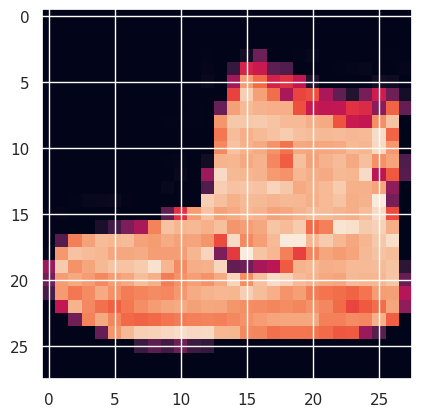

In [ ]:
plt.imshow(dataset_train[0][0])
plt.show()

In [ ]:
dataset_train.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
num_classes = dataset_train.targets.unique().shape[0]
num_classes

10

In [ ]:
model = vgg11_bn(weights=VGG11_BN_Weights.IMAGENET1K_V1)
model

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


100%|██████████| 507M/507M [00:03<00:00, 155MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
temp_transform = T.Compose([
    T.Resize((224, 224)),
    # T.Grayscale(num_output_channels=3),
    T.ToTensor(),
])

dataset_train = FashionMNIST(data_dir, train=True, transform=temp_transform)

# Вычисление mean и std
channels = 1
pixel_sum = torch.zeros(channels)
pixel_squared_sum = torch.zeros(channels)
num_pixels = 0

for img, _ in dataset_train:
    # img имеет форму [3, 224, 224]
    pixel_sum += img.sum(dim=[1, 2])  # Сумма по высоте и ширине
    pixel_squared_sum += (img ** 2).sum(dim=[1, 2])
    num_pixels += img.shape[1] * img.shape[2]  # Высота * Ширина

mean = pixel_sum / num_pixels
# std = sqrt(E[X^2] - (E[X])^2)
std = torch.sqrt((pixel_squared_sum / num_pixels) - (mean ** 2))

print(f"Вычисленные значения: mean={mean.tolist()}, std={std.tolist()}")

# Использование вычисленных значений в преобразованиях
transform = T.Compose([
    T.Resize((224, 224)),
    # T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize(mean=mean.tolist(), std=std.tolist())
])

Вычисленные значения: mean=[0.2861536741256714], std=[0.33859288692474365]


In [ ]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

In [ ]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()  # Переводим модель в режим обучения (активируются dropout, batchnorm и т.д.)
    total_loss = 0      # Суммарная потеря за эпоху
    total_correct = 0   # Счётчик правильных предсказаний
    # Проходим по всем батчам обучающего датасета
    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)  # Переносим данные на GPU/CPU
        optimizer.zero_grad()  # Обнуляем градиенты, накопленные от предыдущих шагов
        output = model(x)      # Прямой проход (forward) через модель
        loss = loss_fn(output, y)  # Вычисляем функцию потерь
        loss.backward()        # Обратное распространение (вычисление градиентов)
        total_loss += loss.item()  # Накапливаем значение потерь
        # Считаем количество правильных предсказаний в батче
        total_correct += (output.argmax(dim=1) == y).sum().item()
        optimizer.step()       # Шаг оптимизации (обновление весов модели)
    # Возвращаем среднюю потерю на батч и точность на всем датасете
    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [ ]:
@torch.inference_mode()  # Отключает вычисление градиентов (экономит память и ускоряет оценку)
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()  # Переводим модель в режим оценки (выключаются dropout, batchnorm работает стабильно)
    total_loss = 0      # Суммарная потеря за весь датасет
    total_correct = 0   # Счётчик правильных предсказаний
    # Проходим по всем батчам в датасете
    for x, y in tqdm(data_loader):
        x, y = x.to(device), y.to(device)  # Переносим данные на GPU/CPU
        output = model(x)       # Прямой проход через модель
        loss = loss_fn(output, y)  # Вычисляем функцию потерь
        total_loss += loss.item()   # Накапливаем потерю
        # Считаем количество правильных предсказаний в батче
        total_correct += (output.argmax(dim=1) == y).sum().item()
    # Возвращаем среднюю потерю и точность на всём датасете
    return total_loss / len(data_loader), total_correct / len(data_loader.dataset)


In [ ]:
sns.set(style='darkgrid')
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    # График ошибки (loss)
    plt.figure(figsize=(16, 8)) # Размер графика
    plt.title(title + ' loss') # Заголовок графика
    plt.plot(train_loss, label='Train loss') # Линия для потерь на обучающем наборе
    plt.plot(valid_loss, label='Valid loss') # Линия для потерь на валидационном наборе
    plt.legend() # Показываем легенду
    plt.show() # Отображаем график
    # График точности (accuracy)
    plt.figure(figsize=(16, 8)) # Размер графика
    plt.title(title + ' accuracy') # Заголовок графика
    plt.plot(train_accuracy, label='Train accuracy') # Линия для точности на обучающем наборе
    plt.plot(valid_accuracy, label='Valid accuracy') # Линия для точности на валидационном наборе
    plt.legend() # Показываем легенду
    plt.show() # Отображаем график


In [ ]:
import os

def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title):
    # Списки для хранения истории ошибки и точности
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    best_valid_accuracy = 0

    # Цикл по эпохам
    for epoch in range(num_epochs):
        # Обучение на одной эпохе
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        # Оценка модели на валидационном наборе
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)
        # Сохраняем историю для графиков
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        # Очищаем вывод и строим графики
        clear_output()
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        # Сохраняем контрольные точки модели и оптимизатора
        checkpoint_dir = "/content/drive/MyDrive/NN_labs/lab_4/checkpoints/"

        checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss_history': train_loss_history,
        'valid_loss_history': valid_loss_history,
        'train_accuracy_history': train_accuracy_history,
        'valid_accuracy_history': valid_accuracy_history,
        }

        if valid_accuracy > best_valid_accuracy:
          best_valid_accuracy = valid_accuracy
          torch.save(checkpoint, os.path.join(checkpoint_dir, "best_checkpoint.pt"))

        # os.makedirs(checkpoint_dir, exist_ok=True) # Создаём папку, если её нет
        torch.save(checkpoint, os.path.join(checkpoint_dir, "last_checkpoint.pt"))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = FashionMNIST(data_dir, train=True, transform=transform)
valid_dataset = FashionMNIST(data_dir, train=False, transform=transform)
# Создаём DataLoader для обучающего набора
train_loader = DataLoader(
    train_dataset, # Dataset
    batch_size=128, # Размер одного батча
    shuffle=True, # Перемешиваем данные на каждой эпохе
    num_workers=8, # Количество потоков для загрузки данных (ускоряет)
    pin_memory=True # Копирование данных в pinned memory для ускорения передачи на GPU
)
# Создаём DataLoader для валидационного набора
valid_loader = DataLoader(
    valid_dataset,
    batch_size=128, # Размер батча
    shuffle=False, # Не перемешиваем, порядок не важен
    num_workers=8,
    pin_memory=True
)

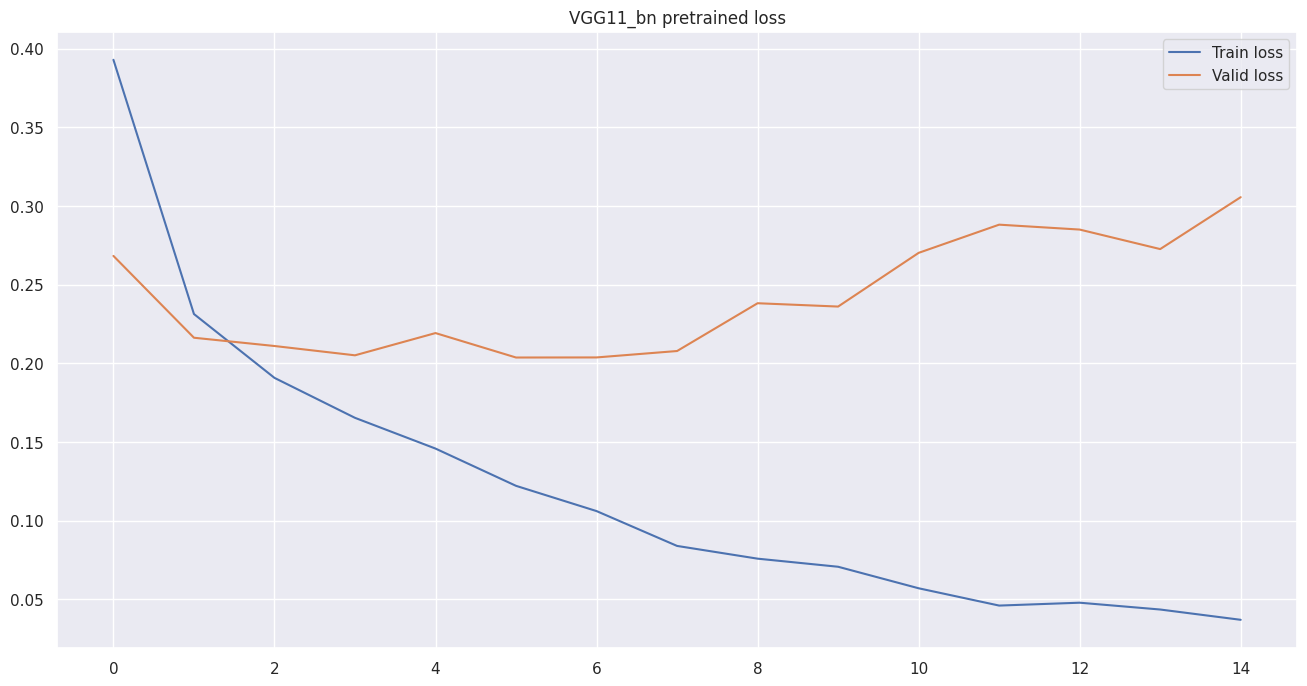

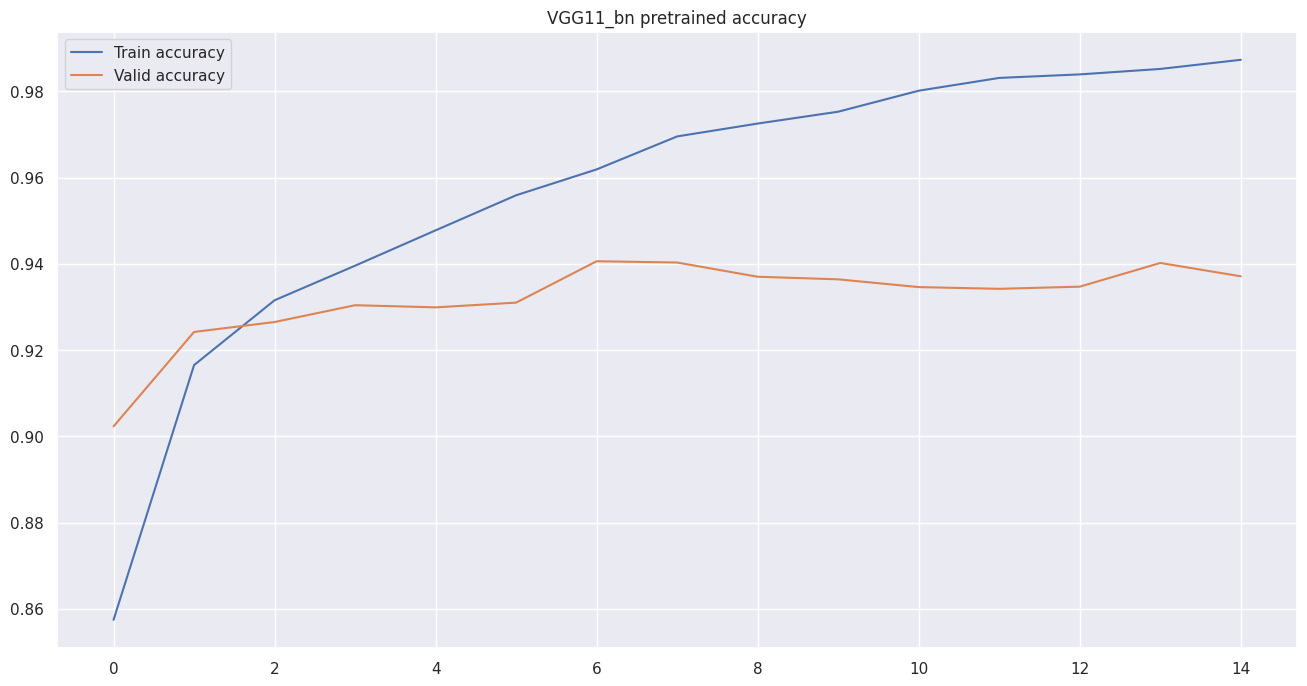

In [ ]:
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
fit(
    model,
    train_loader, valid_loader,
    optimizer, loss_fn, device, 15,  # 10 эпох
    'VGG11_bn pretrained'
)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/NN_labs/lab_4/checkpoints/best_checkpoint.pt", map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [ ]:
valid_dataset[0]

(tensor([[[-0.8451, -0.8451, -0.8451,  ..., -0.8451, -0.8451, -0.8451],
          [-0.8451, -0.8451, -0.8451,  ..., -0.8451, -0.8451, -0.8451],
          [-0.8451, -0.8451, -0.8451,  ..., -0.8451, -0.8451, -0.8451],
          ...,
          [-0.8451, -0.8451, -0.8451,  ..., -0.8451, -0.8451, -0.8451],
          [-0.8451, -0.8451, -0.8451,  ..., -0.8451, -0.8451, -0.8451],
          [-0.8451, -0.8451, -0.8451,  ..., -0.8451, -0.8451, -0.8451]]]),
 9)

In [ ]:
model(valid_dataset[0][0].unsqueeze(0)).argmax(dim=1)

tensor([9])

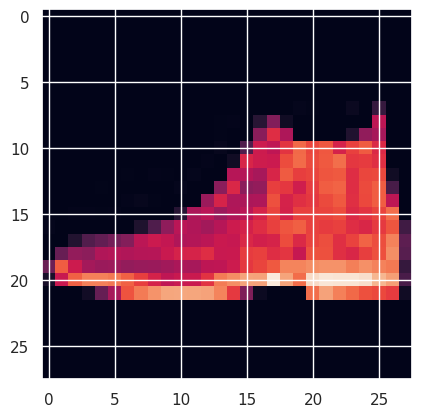

In [ ]:
plt.imshow(FashionMNIST(data_dir, train=False)[0][0])
plt.show()